In [1]:
import os
import sys
import pprint
import csv
import statistics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import radical.pilot as rp
import radical.utils     as ru
import radical.analytics as ra
import rp_analytics as rp_data
import parsl_analytics as parsl_data
from matplotlib import cm
blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys = cm.get_cmap(plt.get_cmap('Greys'))

In [2]:
!radical-stack
!which python


  python               : 3.7.0
  pythonpath           : 
  virtualenv           : /home/aymen/iwp

  radical.analytics    : 0.90.7
  radical.entk         : 1.0.2
  radical.pilot        : 1.3.0
  radical.saga         : 1.3.0
  radical.utils        : 1.3.1

/opt/anaconda3/bin/python


In [3]:
RP    = rp_data.get_session_tstamps()
PARSL = parsl_data.get_session_tstamps()

session loaded
session loaded
session loaded
session loaded
[21.360000000000003, 21.102000000000004, 20.769000000000005, 20.705]


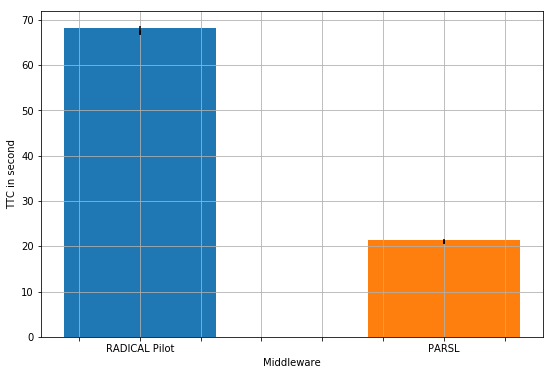

In [4]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(9,6))
RP_gr = statistics.mean(RP)
PARSL_gr = statistics.mean(PARSL)
ax.bar(1,RP,yerr = statistics.stdev(RP), width=0.5)
ax.set_xlabel("Middleware")
ax.set_ylabel("TTC in second")
ax.bar(2,PARSL, yerr = statistics.stdev(PARSL), width=0.5)
ax.grid()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = 'RADICAL Pilot'
labels[7] = 'PARSL'
ax.set_xticklabels(labels)
plt.show()

In [48]:
session = ra.Session(stype='radical.pilot', src='/home/aymen/SummerRadical/Parsl-RP/local-test/RP/sessions/rp.session.js-17-21.jetstream-cloud.org.aymen.018409.0009/')

session loaded


In [49]:
# Durations for events concurrency and scatter plots
event_durations = {
    'Scheduling'         : [{ru.STATE: None, ru.EVENT: 'schedule_try'}              , {ru.STATE: None, ru.EVENT: 'schedule_ok'}],
    'Queuing Execution'  : [{ru.STATE: 'AGENT_EXECUTING_PENDING', ru.EVENT: 'state'}, {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'}],
    'Preparing Execution': [{ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'}        , {ru.STATE: None, ru.EVENT: 'exec_start'}],
    'Making directory'   : [{ru.STATE: None, ru.EVENT: 'exec_mkdir'}                , {ru.STATE: None, ru.EVENT: 'exec_mkdir_done'}],
    'Spawning'           : [{ru.STATE: None, ru.EVENT: 'exec_start'}                , {ru.STATE: None, ru.EVENT: 'exec_ok'}],
    'Executing'          : [{ru.STATE: None, ru.EVENT: 'exec_ok'}                   , {ru.STATE: None, ru.EVENT: 'exec_stop'}],
    'Unscheduling'       : [{ru.STATE: None, ru.EVENT: 'unschedule_start'}          , {ru.STATE: None, ru.EVENT: 'unschedule_stop'}]
}

Text(0, 0.5, 'Number of Units')

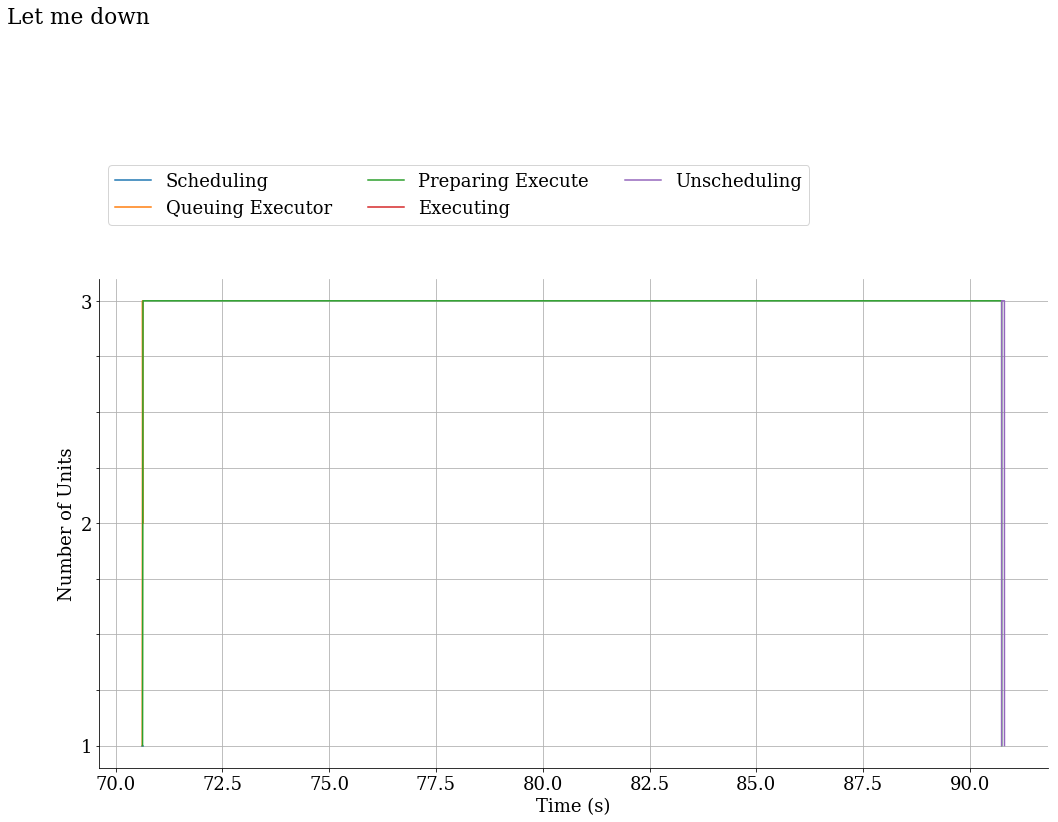

In [50]:
fig, ax = fig_setup()

fig.suptitle('Let me down', x=0.05, y=1.3, horizontalalignment='left')

# How many units are being scheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'schedule_try'},               # Scheduling start
 {ru.STATE: None, ru.EVENT: 'schedule_ok'}])               # Scheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[6])
# How many units are being queued for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING_PENDING', ru.EVENT: 'state'}, # Queuing Execution start
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'}])        # Queuing Execution stop  
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[4])

# How many units are being prepared for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'},         # Preparing Execution start
 {ru.STATE: None, ru.EVENT: 'exec_stop'}])                 # Preparing Execution stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[12])

# How many units are being executed
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'app_start'},                   # Execution start
 {ru.STATE: None, ru.EVENT: 'app_stop'}]   )                # Executed
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[0])

# How many units are being unscheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'unschedule_start'},            # Unscheduling start
 {ru.STATE: None, ru.EVENT: 'unschedule_stop'}])            # Unscheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[8])

ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(0,1.25),
          labels=['Scheduling', 'Queuing Executor', 'Preparing Execute', 
                  # 'Checking Directory', 'Spawning', 
                  'Executing', 'Unscheduling'])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '1'
labels[5] = '2'
labels[9] = '3'
ax.set_yticklabels(labels)
ax.grid()
plt.xlabel('Time (s)')
plt.ylabel('Number of Units')

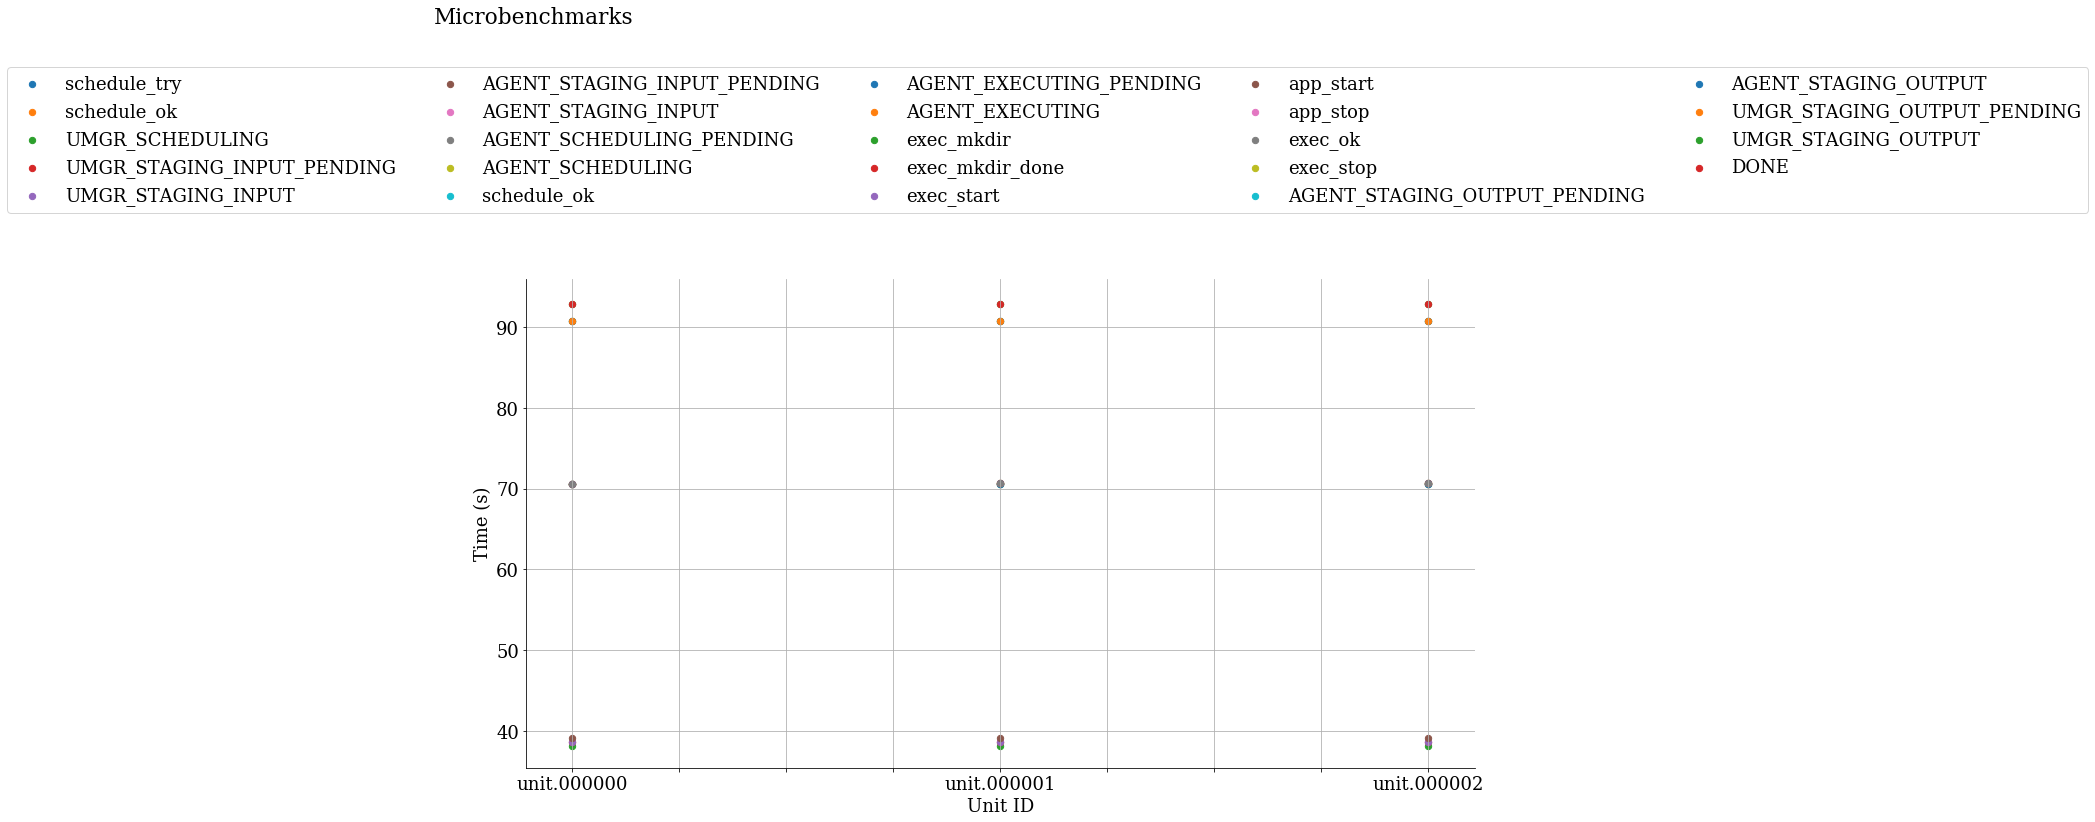

In [51]:
#!/usr/bin/env python

__copyright__ = 'Copyright 2013-2016, http://radical.rutgers.edu'
__license__   = 'MIT'


import sys

import radical.utils     as ru
import radical.analytics as ra

import matplotlib.pyplot as plt
import numpy             as np
from IPython.core.display import display, HTML

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# We plot timelines for all events listed in `event_list` for all entities of
# type `event_entity`..  Before plotting, we sort those entities by the
# timestamp of the first event in the event list

event_entity = 'unit'
event_list   = \
    [
        {ru.STATE: None, ru.EVENT: 'schedule_try'},               # Scheduling start
        {ru.STATE: None, ru.EVENT: 'schedule_ok'},                # Scheduling stop
        {ru.STATE: 'UMGR_SCHEDULING'             , ru.EVENT: 'state'          },
        {ru.STATE: 'UMGR_STAGING_INPUT_PENDING'  , ru.EVENT: 'state'          },
        {ru.STATE: 'UMGR_STAGING_INPUT'          , ru.EVENT: 'state'          },
        {ru.STATE: 'AGENT_STAGING_INPUT_PENDING' , ru.EVENT: 'state'          },
       # {ru.COMP : 'agent_0'                     , ru.EVENT: 'get'            },
        {ru.STATE: 'AGENT_STAGING_INPUT'         , ru.EVENT: 'state'          },
        {ru.STATE: 'AGENT_SCHEDULING_PENDING'    , ru.EVENT: 'state'          },
        {ru.STATE: 'AGENT_SCHEDULING'            , ru.EVENT: 'state'          },
        {ru.STATE: None                          , ru.EVENT: 'schedule_ok'    },
        {ru.STATE: 'AGENT_EXECUTING_PENDING'     , ru.EVENT: 'state'          },
        {ru.STATE: 'AGENT_EXECUTING'             , ru.EVENT: 'state'          },
        {ru.STATE: None                          , ru.EVENT: 'exec_mkdir'     },
        {ru.STATE: None                          , ru.EVENT: 'exec_mkdir_done'},
        {ru.STATE: None                          , ru.EVENT: 'exec_start'     },
        {ru.STATE: None                          , ru.EVENT: 'app_start'      },
        {ru.STATE: None                          , ru.EVENT: 'app_stop'       },
        {ru.STATE: None                          , ru.EVENT: 'exec_ok'        },
        {ru.STATE: None                          , ru.EVENT: 'exec_stop'      },
        {ru.STATE: 'AGENT_STAGING_OUTPUT_PENDING', ru.EVENT: 'state'          },
        {ru.STATE: 'AGENT_STAGING_OUTPUT'        , ru.EVENT: 'state'          },
        {ru.STATE: 'UMGR_STAGING_OUTPUT_PENDING' , ru.EVENT: 'state'          },
        {ru.STATE: 'UMGR_STAGING_OUTPUT'         , ru.EVENT: 'state'          },
        {ru.STATE: 'DONE'                        , ru.EVENT: 'state'          },
    ]


# ------------------------------------------------------------------------------
#
if __name__ == '__main__':


    

    def fig_setup(figsize=None):
        if not figsize:
            figsize = (17,9)
        font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

        matplotlib.rc('font', **font)    
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        return fig, ax
    
    
    # A formatting helper before starting...
    def ppheader(message):
        separator = '\n' + 78 * '-' + '\n'
        print(separator + message + separator)

    data = dict()
    pipe = dict()

    for thing in session.get(etype=event_entity):

        tstamps = list()

        for event in event_list:
            times = thing.timestamps(event=event)
            if times: tstamps.append(times[0])
            else    : tstamps.append(None)

        data[thing.uid] = tstamps
        pipe[thing.uid] = [int(x) for x
                           in thing.description.get('name', '').split()]

    order = 'AGENT_EXECUTING state'
    index = 4

    if order == 'uid':
        sorted_uids = sorted(pipe.keys())
    else:
        sorted_uids = [x[0] for x in sorted(list(data.items()),key=lambda v: v[1][index])]
    sorted_data   = list()
    index         = 0
    for uid in sorted_uids:
        sorted_data.append([index] + data[uid])
        index += 1

    np_data = np.array(sorted_data)

    fig, ax = fig_setup()
    fig.suptitle('Microbenchmarks', x=0.05, y=1.3, horizontalalignment='left')

    for e_idx in range(len(event_list)):
        plt.scatter(np_data[:,0], np_data[:,(1 + e_idx)], label=ru.event_to_label(event_list[e_idx]), s=40)
    
    plt.xlabel('Unit ID')
    plt.ylabel('Time (s)')
    plt.legend(ncol=5, loc='upper center', bbox_to_anchor=(0.55,1.45))
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[1] = 'unit.000000'
    labels[5] = 'unit.000001'
    labels[9] = 'unit.000002'
    ax.set_xticklabels(labels)
    ax.grid()
    plt.show()


# ------------------------------------------------------------------------------

